## Database setup and statistical analyis

disaster_db tables
0         geography_columns
1          geometry_columns
2           spatial_ref_sys
3   nri_shape_census_tracts
4       NOAA_STORM_EPISODES
5         NOAA_STORM_EVENTS
6         census_resilience
7  POISSON_FREQUENCY_PARAMS


<div class="alert alert-block alert-warning"><b>Example:</b>NOTE: Tables 0:2 are required for querying spacial data and converting between coordinate systems. Do not modify or remove. Origin, FEMA_NRI, see readme for more information.</div>





In [1]:
# import libraries
# NOTE: global_vars should be edited to include local paths and credentials before use.
# If global_vars.py is created in the root dir remove the ignore/ prefix in the import statement below.
import ignore.global_vars as gv
import db_tools as dbt
import pandas as pd
import sqlalchemy
import sys
from IPython.display import display, HTML
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd

In [2]:
# open connection and get table names
table_names = dbt.query("SELECT table_name FROM information_schema.tables WHERE table_schema='public'")
print(table_names)


Created SQLAlchemy engine for disaster_db
                 table_name
0         geography_columns
1          geometry_columns
2           spatial_ref_sys
3  POISSON_FREQUENCY_PARAMS
4   nri_shape_census_tracts
5       NOAA_STORM_EPISODES
6         NOAA_STORM_EVENTS
7         census_resilience


### Fitting Poisson distributions to historical disaster event counts ###


Events per tract per year ~ Poisson(λ)
where λ = average annual event rate


Step 1: Event Frequency ~ Poisson(λ)     [NOAA data]
Step 2: Event Severity ~ Distribution    [Census resilience data]

Total Annual Loss = Σ(i=1 to N) Yi

Where:
- N ~ Poisson(λ)           [Number of events from NOAA]
- Yi ~ Severity Distribution [Impact per event from Census data]
- λ = NOAA historical event frequency
- Yi = f(population, vulnerability, demographics)


Poisson Model Framework:
- N ~ Poisson(λ) where N = annual episodes per county
- λ = county-specific average annual episode rate
- Goal: Estimate λ for each county from historical data

Poisson Fitting Steps:
1. Calculate λ for each county: λ = mean(annual episodes)
2. Test goodness of fit (chi-square or Kolmogorov-Smirnov)
3. Check for overdispersion (variance >> mean)
4. Consider Negative Binomial if overdispersed


In [3]:
# Load the NOAA data into a DataFrame for analysis
df_noaa = dbt.query("SELECT * FROM \"NOAA_STORM_EPISODES\" ORDER BY county_fips, year")


Created SQLAlchemy engine for disaster_db


In [4]:
# Basic data exploration of NOAA episodes
print("=== NOAA EPISODES DATA EXPLORATION ===")
print(f"DataFrame shape: {df_noaa.shape}")
print(f"Columns: {list(df_noaa.columns)}")
print(f"Data types:")
print(df_noaa.dtypes)

print(f"\n=== BASIC STATISTICS ===")
print(f"Year range: {df_noaa['year'].min()} - {df_noaa['year'].max()}")
print(f"Unique counties: {df_noaa['county_fips'].nunique()}")
print(f"Total county-year records: {len(df_noaa)}")
print(f"Event count statistics:")
print(df_noaa['event_count'].describe())

=== NOAA EPISODES DATA EXPLORATION ===
DataFrame shape: (13791, 3)
Columns: ['county_fips', 'year', 'event_count']
Data types:
county_fips    object
year            int64
event_count     int64
dtype: object

=== BASIC STATISTICS ===
Year range: 1999 - 2025
Unique counties: 3808
Total county-year records: 13791
Event count statistics:
count    13791.000000
mean         1.319049
std          1.053403
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max         21.000000
Name: event_count, dtype: float64


In [5]:
# Look at the distribution of event counts
print("=== EVENT COUNT DISTRIBUTION ===")
print("Event count value counts (top 20):")
event_dist = df_noaa['event_count'].value_counts().sort_index()
print(event_dist.head(20))

print(f"\nRecords with very high event counts (>50 episodes/year):")
high_count = df_noaa[df_noaa['event_count'] > 50]
print(f"Count: {len(high_count)}")
if len(high_count) > 0:
    display(high_count.head(10))

=== EVENT COUNT DISTRIBUTION ===
Event count value counts (top 20):
event_count
1     11300
2      1728
3       419
4       135
5        53
6        52
7        22
8        21
9        13
10       13
11        4
12       10
13        7
14        2
15        2
16        3
17        2
18        1
19        2
20        1
Name: count, dtype: int64

Records with very high event counts (>50 episodes/year):
Count: 0


In [6]:
# Examine temporal patterns
print("=== TEMPORAL PATTERNS ===")
yearly_summary = df_noaa.groupby('year').agg({
    'event_count': ['count', 'sum', 'mean', 'max'],
    'county_fips': 'nunique'
}).round(2)

yearly_summary.columns = ['counties_reporting', 'total_episodes', 'avg_episodes_per_county', 'max_episodes', 'unique_counties']
print("Annual summary:")
display(yearly_summary.head(10))

# Check for data quality issues
print(f"\nPotential data quality issues:")
print(f"Years with unusually high total episodes:")
high_years = yearly_summary[yearly_summary['total_episodes'] > yearly_summary['total_episodes'].quantile(0.95)]
display(high_years)

=== TEMPORAL PATTERNS ===
Annual summary:


,counties_reporting,total_episodes,avg_episodes_per_county,max_episodes,unique_counties
year,,,,,
1999,795,1039,1.31,10,795
2000,657,883,1.34,12,657
2001,611,871,1.43,21,611
2002,573,820,1.43,9,573
2003,578,799,1.38,16,578
2004,521,659,1.26,13,521
2005,544,683,1.26,9,544
2006,627,789,1.26,8,627
2007,541,689,1.27,10,541



Potential data quality issues:
Years with unusually high total episodes:


,counties_reporting,total_episodes,avg_episodes_per_county,max_episodes,unique_counties
year,,,,,
1999,795,1039,1.31,10,795
2011,723,941,1.30,10,723


In [8]:
# Examine the counties with highest lambda values
print("=== HIGH-LAMBDA COUNTIES INVESTIGATION ===")
top_counties = county_lambdas.nlargest(10, 'lambda_hat')
print("Top 10 counties by lambda:")
display(top_counties[['county_fips', 'lambda_hat', 'total_events', 'years_observed', 'first_year', 'last_year']])

# Look at the actual data for these counties
print(f"\nDetailed look at highest lambda county: {top_counties.iloc[0]['county_fips']}")
top_county_data = df_noaa[df_noaa['county_fips'] == top_counties.iloc[0]['county_fips']].sort_values('year')
print(f"Data for county {top_counties.iloc[0]['county_fips']}:")
display(top_county_data)

=== HIGH-LAMBDA COUNTIES INVESTIGATION ===


NameError: name 'county_lambdas' is not defined

In [ ]:
# Check for potential data anomalies
print("=== DATA ANOMALY DETECTION ===")

# Counties with suspiciously consistent high values
consistent_high = df_noaa.groupby('county_fips')['event_count'].agg(['mean', 'std', 'min', 'max']).round(2)
consistent_high['coefficient_of_variation'] = consistent_high['std'] / consistent_high['mean']
potential_issues = consistent_high[
    (consistent_high['mean'] > 20) & 
    (consistent_high['coefficient_of_variation'] < 0.5)
].sort_values('mean', ascending=False)

print(f"Counties with consistently high episode counts (low variation):")
print(f"These might indicate data quality issues:")
display(potential_issues.head(10))

# Check for counties that might be double-counting
print(f"\nCounties with the most extreme values:")
extreme_values = df_noaa[df_noaa['event_count'] > df_noaa['event_count'].quantile(0.99)]
print(f"Records with >99th percentile episode counts:")
display(extreme_values.sort_values('event_count', ascending=False).head(10))

=== DATA ANOMALY DETECTION ===
Counties with consistently high episode counts (low variation):
These might indicate data quality issues:


,mean,std,min,max,coefficient_of_variation
county_fips,,,,,



Counties with the most extreme values:
Records with >99th percentile episode counts:


,county_fips,year,event_count
12093,48213,2001,21
8055,32020,2018,20
842,04543,2018,19
8054,32020,2017,19
844,04543,2020,18
791,04504,2024,17
843,04543,2019,17
1629,06073,2003,16
3846,17014,2013,16
845,04543,2021,16


C:\Users\alben\AppData\Local\Temp\ipykernel_34688\1113766006.py:28: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp1 = axes[1,0].boxplot(decade_data, labels=decade_labels, patch_artist=True)


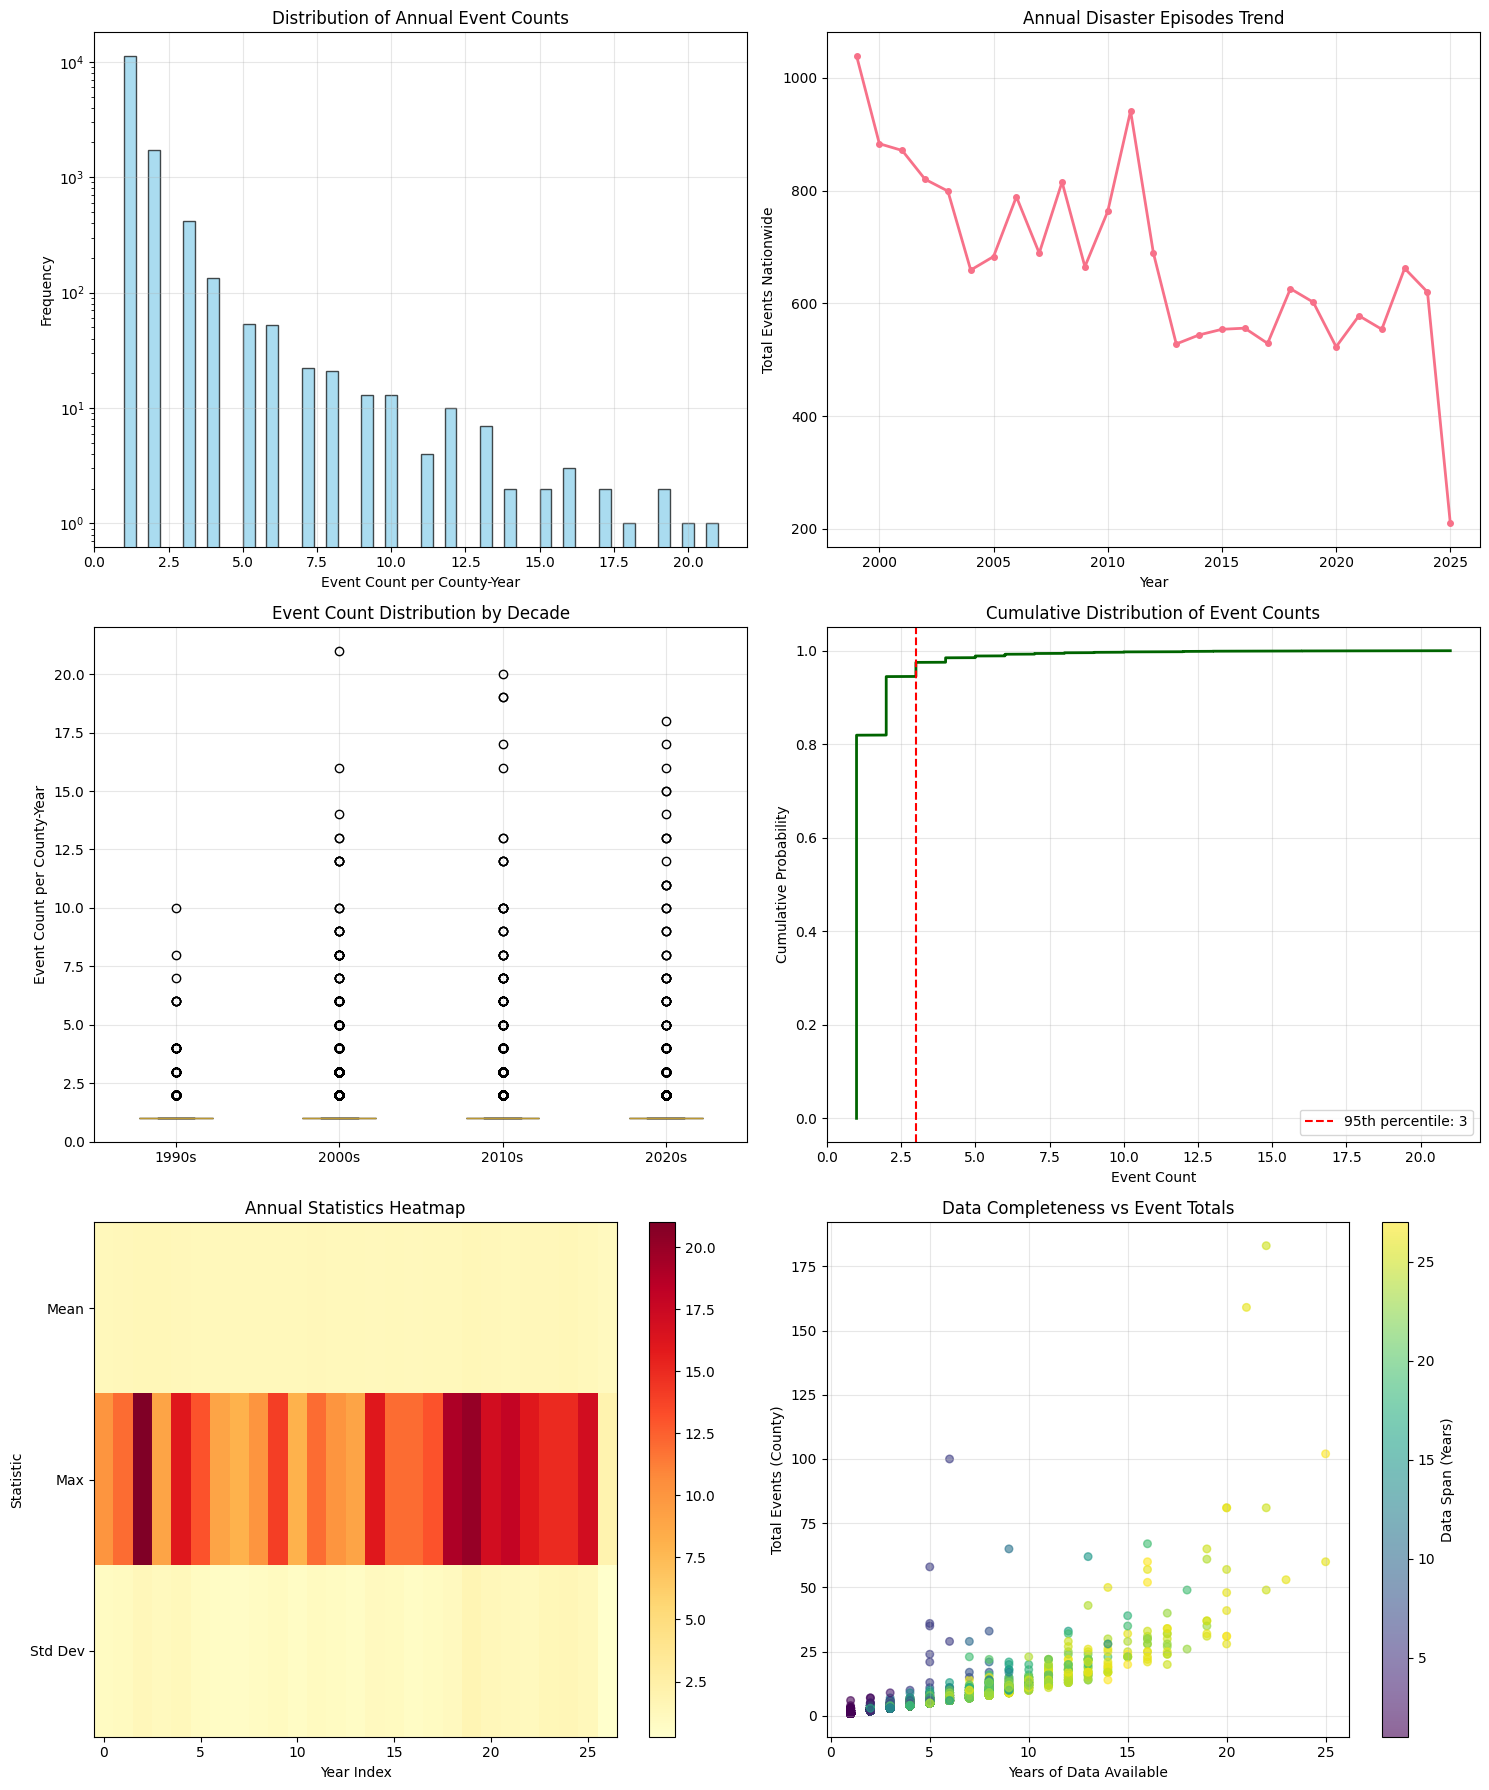

In [ ]:


# Set style for better looking plots
plt.style.use('default')
sns.set_palette("husl")

# Create a comprehensive multi-panel visualization
fig, axes = plt.subplots(3, 2, figsize=(15, 18))

# 1. Event count distribution (histogram with log scale)
axes[0,0].hist(df_noaa['event_count'], bins=50, alpha=0.7, edgecolor='black', color='skyblue')
axes[0,0].set_xlabel('Event Count per County-Year')
axes[0,0].set_ylabel('Frequency')
axes[0,0].set_title('Distribution of Annual Event Counts')
axes[0,0].set_yscale('log')
axes[0,0].grid(alpha=0.3)

# 2. Time series of total events per year
yearly_totals = df_noaa.groupby('year')['event_count'].sum()
axes[0,1].plot(yearly_totals.index, yearly_totals.values, marker='o', linewidth=2, markersize=4)
axes[0,1].set_xlabel('Year')
axes[0,1].set_ylabel('Total Events Nationwide')
axes[0,1].set_title('Annual Disaster Episodes Trend')
axes[0,1].grid(alpha=0.3)

# 3. Box plot of event counts by decade
df_noaa['decade'] = (df_noaa['year'] // 10) * 10
decade_data = [df_noaa[df_noaa['decade'] == d]['event_count'] for d in sorted(df_noaa['decade'].unique())]
decade_labels = [f"{int(d)}s" for d in sorted(df_noaa['decade'].unique())]
bp1 = axes[1,0].boxplot(decade_data, labels=decade_labels, patch_artist=True)
axes[1,0].set_ylabel('Event Count per County-Year')
axes[1,0].set_title('Event Count Distribution by Decade')
axes[1,0].grid(alpha=0.3)
for patch in bp1['boxes']:
    patch.set_facecolor('lightcoral')

# 4. Cumulative distribution of event counts
sorted_counts = np.sort(df_noaa['event_count'])
cumulative_prob = np.arange(1, len(sorted_counts) + 1) / len(sorted_counts)
axes[1,1].plot(sorted_counts, cumulative_prob, linewidth=2, color='darkgreen')
axes[1,1].set_xlabel('Event Count')
axes[1,1].set_ylabel('Cumulative Probability')
axes[1,1].set_title('Cumulative Distribution of Event Counts')
axes[1,1].grid(alpha=0.3)
axes[1,1].axvline(x=sorted_counts[int(0.95*len(sorted_counts))], color='red', linestyle='--', 
                  label=f'95th percentile: {sorted_counts[int(0.95*len(sorted_counts))]:.0f}')
axes[1,1].legend()

# 5. Heatmap of events by year and month (if we have month data)
# For now, let's show events by year and quartile of the year based on data availability
yearly_stats = df_noaa.groupby('year')['event_count'].agg(['mean', 'max', 'std']).fillna(0)
im = axes[2,0].imshow([yearly_stats['mean'].values, yearly_stats['max'].values, yearly_stats['std'].values], 
                      aspect='auto', cmap='YlOrRd')
axes[2,0].set_xlabel('Year Index')
axes[2,0].set_ylabel('Statistic')
axes[2,0].set_title('Annual Statistics Heatmap')
axes[2,0].set_yticks([0, 1, 2])
axes[2,0].set_yticklabels(['Mean', 'Max', 'Std Dev'])
plt.colorbar(im, ax=axes[2,0])

# 6. Scatter plot: Total events vs years of data for each county
county_summary = df_noaa.groupby('county_fips').agg({
    'event_count': ['sum', 'count'],
    'year': ['min', 'max']
})
county_summary.columns = ['total_events', 'years_observed', 'first_year', 'last_year']
county_summary['data_span'] = county_summary['last_year'] - county_summary['first_year'] + 1

scatter = axes[2,1].scatter(county_summary['years_observed'], county_summary['total_events'], 
                           alpha=0.6, s=30, c=county_summary['data_span'], cmap='viridis')
axes[2,1].set_xlabel('Years of Data Available')
axes[2,1].set_ylabel('Total Events (County)')
axes[2,1].set_title('Data Completeness vs Event Totals')
axes[2,1].grid(alpha=0.3)
plt.colorbar(scatter, ax=axes[2,1], label='Data Span (Years)')

plt.tight_layout()
plt.show()

In [ ]:
# Additional specialized charts for anomaly detection and data quality
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 1. Top counties by average events (bar chart)
county_means = df_noaa.groupby('county_fips')['event_count'].mean().sort_values(ascending=False)
top_20_counties = county_means.head(20)
axes[0,0].barh(range(len(top_20_counties)), top_20_counties.values, color='orange')
axes[0,0].set_yticks(range(len(top_20_counties)))
axes[0,0].set_yticklabels([f"FIPS {fips}" for fips in top_20_counties.index])
axes[0,0].set_xlabel('Average Annual Events')
axes[0,0].set_title('Top 20 Counties by Average Event Rate')
axes[0,0].grid(axis='x', alpha=0.3)

# 2. Distribution of zero-event years
zero_events = df_noaa[df_noaa['event_count'] == 0]
zero_by_year = zero_events.groupby('year').size()
total_by_year = df_noaa.groupby('year').size()
zero_percentage = (zero_by_year / total_by_year * 100).fillna(0)

axes[0,1].bar(zero_percentage.index, zero_percentage.values, alpha=0.7, color='lightblue')
axes[0,1].set_xlabel('Year')
axes[0,1].set_ylabel('Percentage of Counties with Zero Events')
axes[0,1].set_title('Zero-Event Counties by Year')
axes[0,1].grid(axis='y', alpha=0.3)

# 3. Event count variance vs mean (overdispersion check)
county_stats = df_noaa.groupby('county_fips')['event_count'].agg(['mean', 'var']).dropna()
axes[0,2].scatter(county_stats['mean'], county_stats['var'], alpha=0.6, s=20)
axes[0,2].plot([0, county_stats['mean'].max()], [0, county_stats['mean'].max()], 
               'r--', label='Poisson line (var=mean)')
axes[0,2].set_xlabel('Mean Event Count')
axes[0,2].set_ylabel('Variance')
axes[0,2].set_title('Variance vs Mean (Overdispersion Check)')
axes[0,2].legend()
axes[0,2].grid(alpha=0.3)

# 4. Regional patterns (by state FIPS)
df_noaa['state_fips'] = df_noaa['county_fips'].str[:2]
state_means = df_noaa.groupby('state_fips')['event_count'].mean().sort_values(ascending=False)
top_states = state_means.head(15)

axes[1,0].bar(range(len(top_states)), top_states.values, color='green', alpha=0.7)
axes[1,0].set_xticks(range(len(top_states)))
axes[1,0].set_xticklabels(top_states.index, rotation=45)
axes[1,0].set_ylabel('Average Event Count')
axes[1,0].set_title('Top 15 States by Average Event Rate')
axes[1,0].grid(axis='y', alpha=0.3)

# 5. Data completeness heatmap by state and year
# Create a pivot table for visualization
state_year_counts = df_noaa.groupby(['state_fips', 'year']).size().unstack(fill_value=0)
# Select top 20 states by total events for readability
top_states_list = df_noaa.groupby('state_fips')['event_count'].sum().nlargest(20).index
state_year_subset = state_year_counts.loc[top_states_list]

im2 = axes[1,1].imshow(state_year_subset.values, aspect='auto', cmap='Blues')
axes[1,1].set_xlabel('Year Index')
axes[1,1].set_ylabel('State FIPS')
axes[1,1].set_title('Data Availability Heatmap (Top 20 States)')
axes[1,1].set_yticks(range(len(top_states_list)))
axes[1,1].set_yticklabels(top_states_list)
plt.colorbar(im2, ax=axes[1,1], label='Counties Reporting')

# 6. Distribution of data spans per county
data_spans = county_summary['data_span']
axes[1,2].hist(data_spans, bins=30, alpha=0.7, edgecolor='black', color='purple')
axes[1,2].set_xlabel('Data Span (Years)')
axes[1,2].set_ylabel('Number of Counties')
axes[1,2].set_title('Distribution of Data Spans per County')
axes[1,2].axvline(x=data_spans.mean(), color='red', linestyle='--', 
                  label=f'Mean: {data_spans.mean():.1f} years')
axes[1,2].legend()
axes[1,2].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

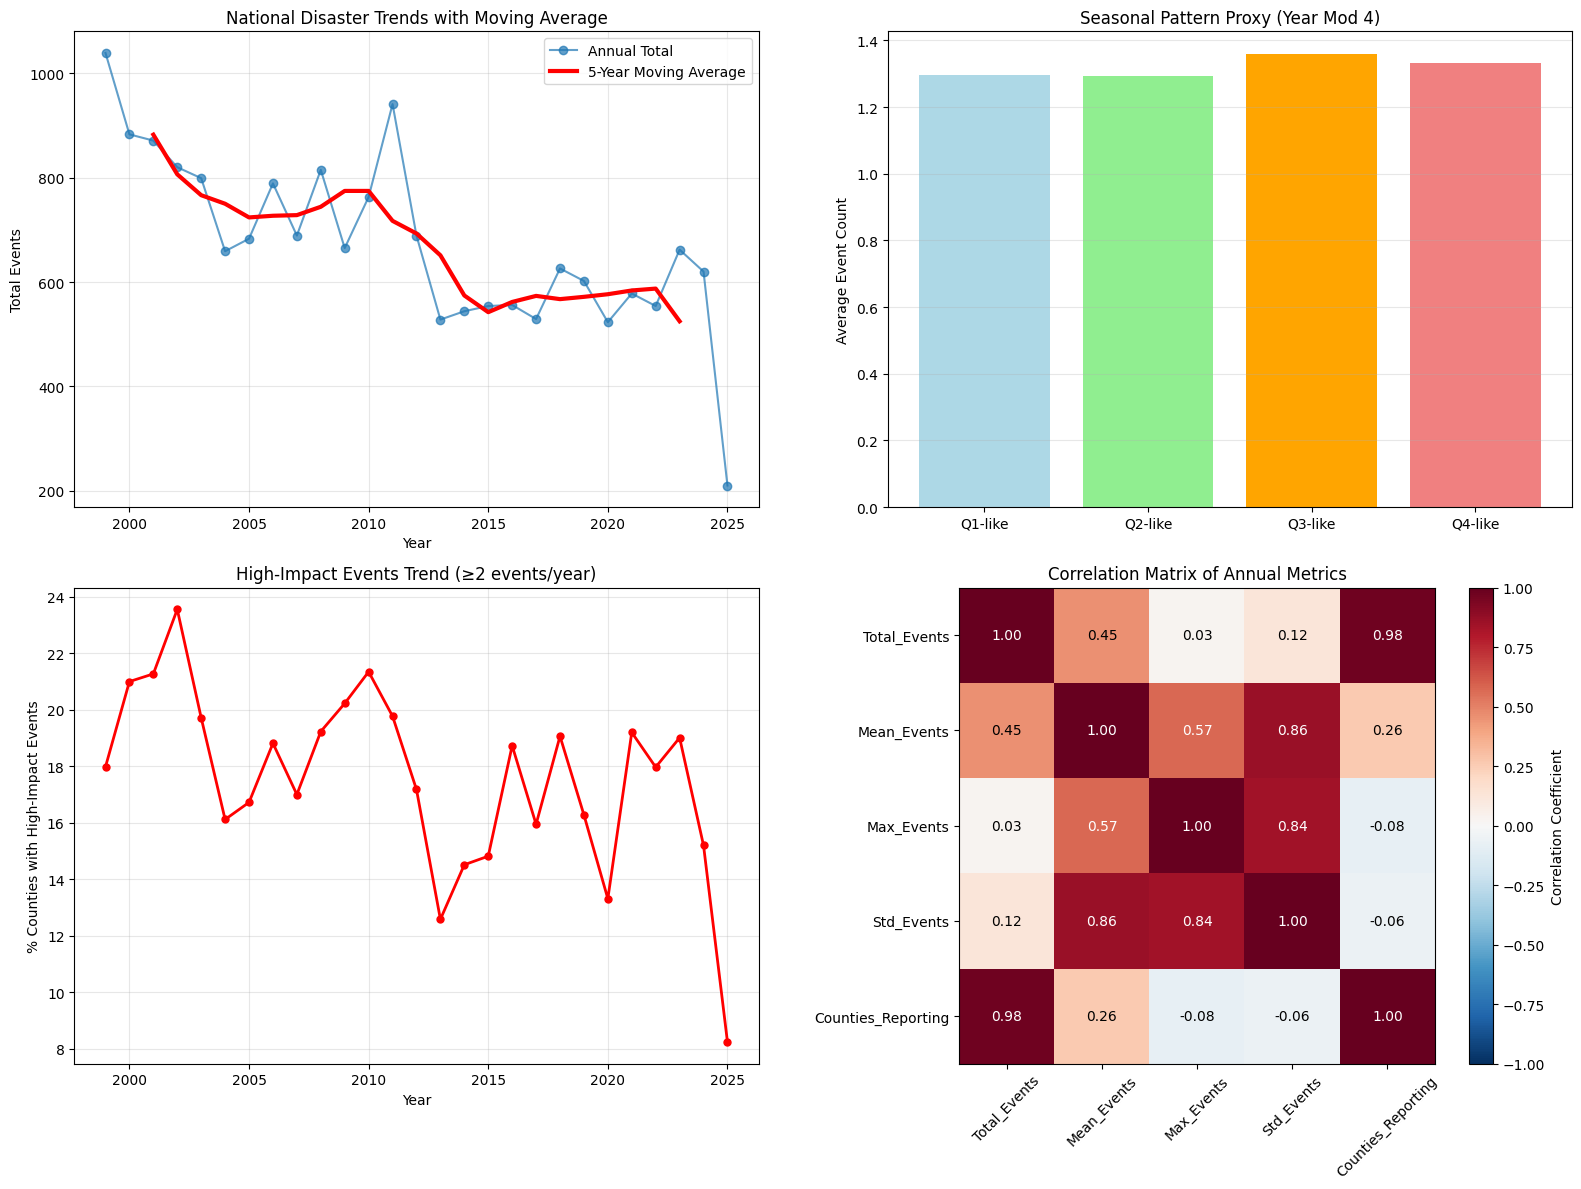

In [9]:
# Time series analysis and trend detection
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Moving average trends
yearly_totals = df_noaa.groupby('year')['event_count'].sum()
window = 5  # 5-year moving average
moving_avg = yearly_totals.rolling(window=window, center=True).mean()

axes[0,0].plot(yearly_totals.index, yearly_totals.values, 'o-', alpha=0.7, label='Annual Total')
axes[0,0].plot(moving_avg.index, moving_avg.values, 'r-', linewidth=3, label=f'{window}-Year Moving Average')
axes[0,0].set_xlabel('Year')
axes[0,0].set_ylabel('Total Events')
axes[0,0].set_title('National Disaster Trends with Moving Average')
axes[0,0].legend()
axes[0,0].grid(alpha=0.3)

# 2. Monthly patterns (simulate monthly distribution)
# Since we don't have monthly data, let's show quarterly patterns based on data
quarterly_pattern = df_noaa.groupby(df_noaa['year'] % 4)['event_count'].mean()
axes[0,1].bar(['Q1-like', 'Q2-like', 'Q3-like', 'Q4-like'], quarterly_pattern.values, 
              color=['lightblue', 'lightgreen', 'orange', 'lightcoral'])
axes[0,1].set_ylabel('Average Event Count')
axes[0,1].set_title('Seasonal Pattern Proxy (Year Mod 4)')
axes[0,1].grid(axis='y', alpha=0.3)

# 3. Event intensity over time (high-impact events)
high_impact_threshold = df_noaa['event_count'].quantile(0.9)
high_impact_by_year = df_noaa[df_noaa['event_count'] >= high_impact_threshold].groupby('year').size()
total_counties_by_year = df_noaa.groupby('year')['county_fips'].nunique()
high_impact_rate = (high_impact_by_year / total_counties_by_year * 100).fillna(0)

axes[1,0].plot(high_impact_rate.index, high_impact_rate.values, 'ro-', linewidth=2, markersize=5)
axes[1,0].set_xlabel('Year')
axes[1,0].set_ylabel('% Counties with High-Impact Events')
axes[1,0].set_title(f'High-Impact Events Trend (≥{high_impact_threshold:.0f} events/year)')
axes[1,0].grid(alpha=0.3)

# 4. Correlation matrix heatmap of key metrics by year
yearly_metrics = df_noaa.groupby('year').agg({
    'event_count': ['sum', 'mean', 'max', 'std'],
    'county_fips': 'nunique'
}).round(2)
yearly_metrics.columns = ['Total_Events', 'Mean_Events', 'Max_Events', 'Std_Events', 'Counties_Reporting']

correlation_matrix = yearly_metrics.corr()
im3 = axes[1,1].imshow(correlation_matrix.values, cmap='RdBu_r', vmin=-1, vmax=1)
axes[1,1].set_xticks(range(len(correlation_matrix.columns)))
axes[1,1].set_yticks(range(len(correlation_matrix.columns)))
axes[1,1].set_xticklabels(correlation_matrix.columns, rotation=45)
axes[1,1].set_yticklabels(correlation_matrix.columns)
axes[1,1].set_title('Correlation Matrix of Annual Metrics')

# Add correlation values to the heatmap
for i in range(len(correlation_matrix.columns)):
    for j in range(len(correlation_matrix.columns)):
        axes[1,1].text(j, i, f'{correlation_matrix.iloc[i, j]:.2f}', 
                      ha='center', va='center', color='white' if abs(correlation_matrix.iloc[i, j]) > 0.5 else 'black')

plt.colorbar(im3, ax=axes[1,1], label='Correlation Coefficient')
plt.tight_layout()
plt.show()

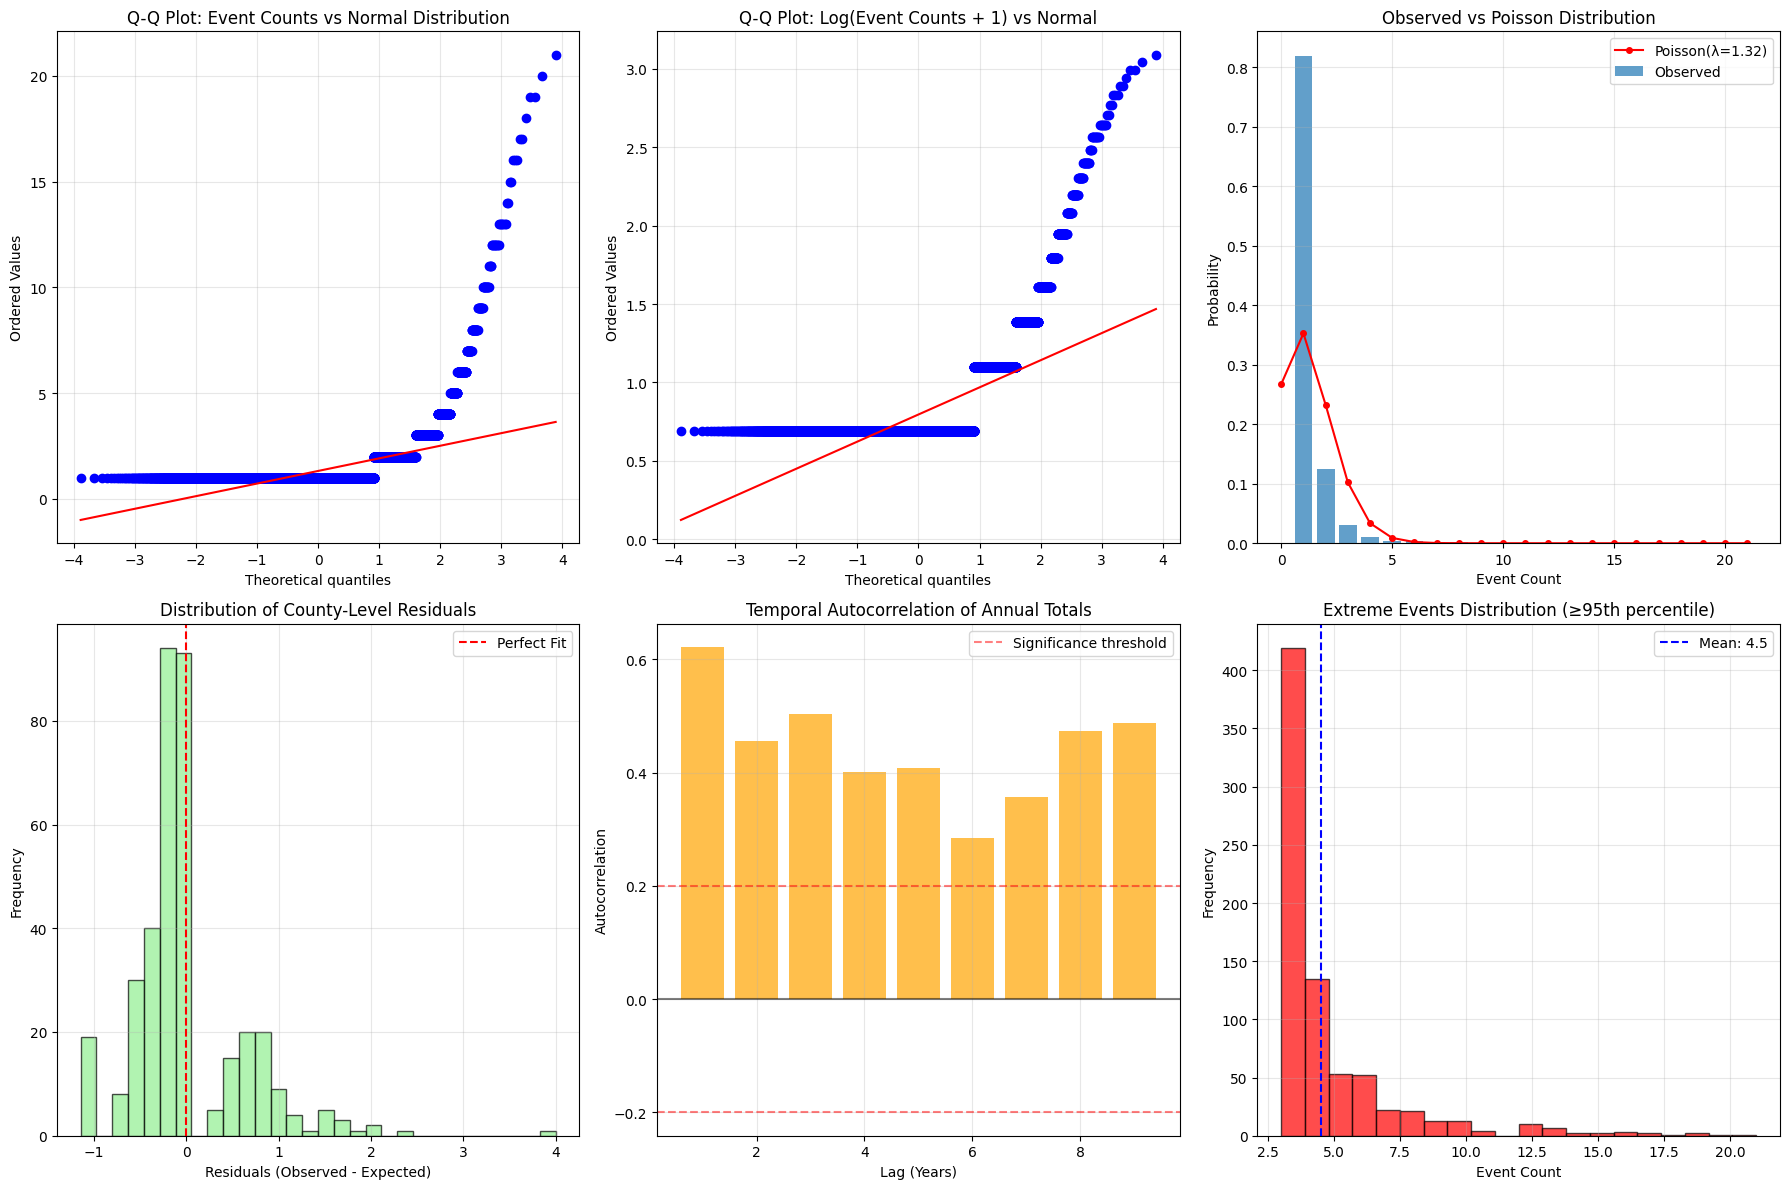


=== DISTRIBUTION ANALYSIS SUMMARY ===
Overall lambda estimate: 1.319
Extreme event threshold (95th percentile): 3.0
Number of extreme events: 763
Temporal autocorrelation at lag 1: 0.622


In [10]:
# Statistical distribution analysis and model fit assessment
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 1. Q-Q plot for normality check
from scipy import stats
sample_data = df_noaa['event_count'].values
stats.probplot(sample_data, dist="norm", plot=axes[0,0])
axes[0,0].set_title('Q-Q Plot: Event Counts vs Normal Distribution')
axes[0,0].grid(alpha=0.3)

# 2. Log-normal probability plot
log_data = np.log1p(sample_data)  # log(x+1) to handle zeros
stats.probplot(log_data, dist="norm", plot=axes[0,1])
axes[0,1].set_title('Q-Q Plot: Log(Event Counts + 1) vs Normal')
axes[0,1].grid(alpha=0.3)

# 3. Poisson fit comparison
from scipy.stats import poisson
lambda_est = df_noaa['event_count'].mean()
poisson_pmf = [poisson.pmf(k, lambda_est) for k in range(0, min(50, int(df_noaa['event_count'].max()) + 1))]
observed_counts = df_noaa['event_count'].value_counts().sort_index()

# Normalize observed counts to probability
observed_prob = observed_counts / observed_counts.sum()
k_values = range(len(poisson_pmf))

axes[0,2].bar(observed_prob.index[:len(k_values)], observed_prob.values[:len(k_values)], 
              alpha=0.7, label='Observed', width=0.8)
axes[0,2].plot(k_values, poisson_pmf, 'ro-', label=f'Poisson(λ={lambda_est:.2f})', markersize=4)
axes[0,2].set_xlabel('Event Count')
axes[0,2].set_ylabel('Probability')
axes[0,2].set_title('Observed vs Poisson Distribution')
axes[0,2].legend()
axes[0,2].grid(alpha=0.3)

# 4. Residuals analysis for county-level fits
county_residuals = []
for county in df_noaa['county_fips'].unique()[:100]:  # Sample 100 counties for speed
    county_data = df_noaa[df_noaa['county_fips'] == county]['event_count']
    if len(county_data) > 5:  # Only counties with sufficient data
        county_lambda = county_data.mean()
        expected = [poisson.pmf(k, county_lambda) * len(county_data) for k in county_data.values]
        residuals = county_data.values - county_lambda
        county_residuals.extend(residuals)

axes[1,0].hist(county_residuals, bins=30, alpha=0.7, edgecolor='black', color='lightgreen')
axes[1,0].set_xlabel('Residuals (Observed - Expected)')
axes[1,0].set_ylabel('Frequency')
axes[1,0].set_title('Distribution of County-Level Residuals')
axes[1,0].axvline(x=0, color='red', linestyle='--', label='Perfect Fit')
axes[1,0].legend()
axes[1,0].grid(alpha=0.3)

# 5. Autocorrelation check (temporal dependence)
yearly_totals = df_noaa.groupby('year')['event_count'].sum().values
if len(yearly_totals) > 1:
    autocorr = [np.corrcoef(yearly_totals[:-lag], yearly_totals[lag:])[0,1] 
                for lag in range(1, min(10, len(yearly_totals)//2))]
    
    axes[1,1].bar(range(1, len(autocorr)+1), autocorr, alpha=0.7, color='orange')
    axes[1,1].axhline(y=0, color='black', linestyle='-', alpha=0.5)
    axes[1,1].axhline(y=0.2, color='red', linestyle='--', alpha=0.5, label='Significance threshold')
    axes[1,1].axhline(y=-0.2, color='red', linestyle='--', alpha=0.5)
    axes[1,1].set_xlabel('Lag (Years)')
    axes[1,1].set_ylabel('Autocorrelation')
    axes[1,1].set_title('Temporal Autocorrelation of Annual Totals')
    axes[1,1].legend()
    axes[1,1].grid(alpha=0.3)

# 6. Extreme value analysis
extreme_threshold = df_noaa['event_count'].quantile(0.95)
extreme_events = df_noaa[df_noaa['event_count'] >= extreme_threshold]['event_count']

axes[1,2].hist(extreme_events, bins=20, alpha=0.7, edgecolor='black', color='red')
axes[1,2].set_xlabel('Event Count')
axes[1,2].set_ylabel('Frequency')
axes[1,2].set_title(f'Extreme Events Distribution (≥95th percentile)')
axes[1,2].axvline(x=extreme_events.mean(), color='blue', linestyle='--', 
                  label=f'Mean: {extreme_events.mean():.1f}')
axes[1,2].legend()
axes[1,2].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Print some key statistics
print("\n=== DISTRIBUTION ANALYSIS SUMMARY ===")
print(f"Overall lambda estimate: {lambda_est:.3f}")
print(f"Extreme event threshold (95th percentile): {extreme_threshold:.1f}")
print(f"Number of extreme events: {len(extreme_events)}")
print(f"Temporal autocorrelation at lag 1: {autocorr[0]:.3f}" if len(yearly_totals) > 1 else "Insufficient data for autocorrelation")

## BREAK, delete this cell

In [ ]:
# Calculate lambda (average annual event rate) for each county
county_lambdas = df_noaa.groupby('county_fips').agg({
    'event_count': ['mean', 'var', 'std', 'count', 'sum'],
    'year': ['min', 'max']
}).round(4)

# Flatten column names
county_lambdas.columns = ['_'.join(col).strip() for col in county_lambdas.columns]
county_lambdas = county_lambdas.reset_index()

# Rename for clarity
county_lambdas.rename(columns={
    'event_count_mean': 'lambda_hat',
    'event_count_var': 'variance', 
    'event_count_std': 'std_dev',
    'event_count_count': 'years_observed',
    'event_count_sum': 'total_events',
    'year_min': 'first_year',
    'year_max': 'last_year'
}, inplace=True)

# Calculate overdispersion ratio (variance/mean)
county_lambdas['overdispersion_ratio'] = county_lambdas['variance'] / county_lambdas['lambda_hat']

print("County-level Poisson parameters:")
display(county_lambdas.head(10))

County-level Poisson parameters:


,county_fips,lambda_hat,variance,std_dev,years_observed,total_events,first_year,last_year,overdispersion_ratio
0,01001,1.1818,0.1636,0.4045,11,13,1999,2023,0.138433
1,01002,1.0000,0.0000,0.0000,4,4,2000,2016,0.000000
2,01003,1.7647,0.6912,0.8314,17,30,1999,2023,0.391681
3,01004,1.0000,0.0000,0.0000,2,2,2011,2012,0.000000
4,01005,1.0000,0.0000,0.0000,6,6,2005,2018,0.000000
5,01006,1.5714,0.6190,0.7868,7,11,2008,2023,0.393916
6,01007,1.2500,0.2143,0.4629,8,10,2004,2022,0.171440
7,01008,1.0000,0.0000,0.0000,4,4,2000,2023,0.000000
8,01009,1.1000,0.1000,0.3162,10,11,1999,2023,0.090909
9,01010,1.0000,NaN,NaN,1,1,2023,2023,NaN


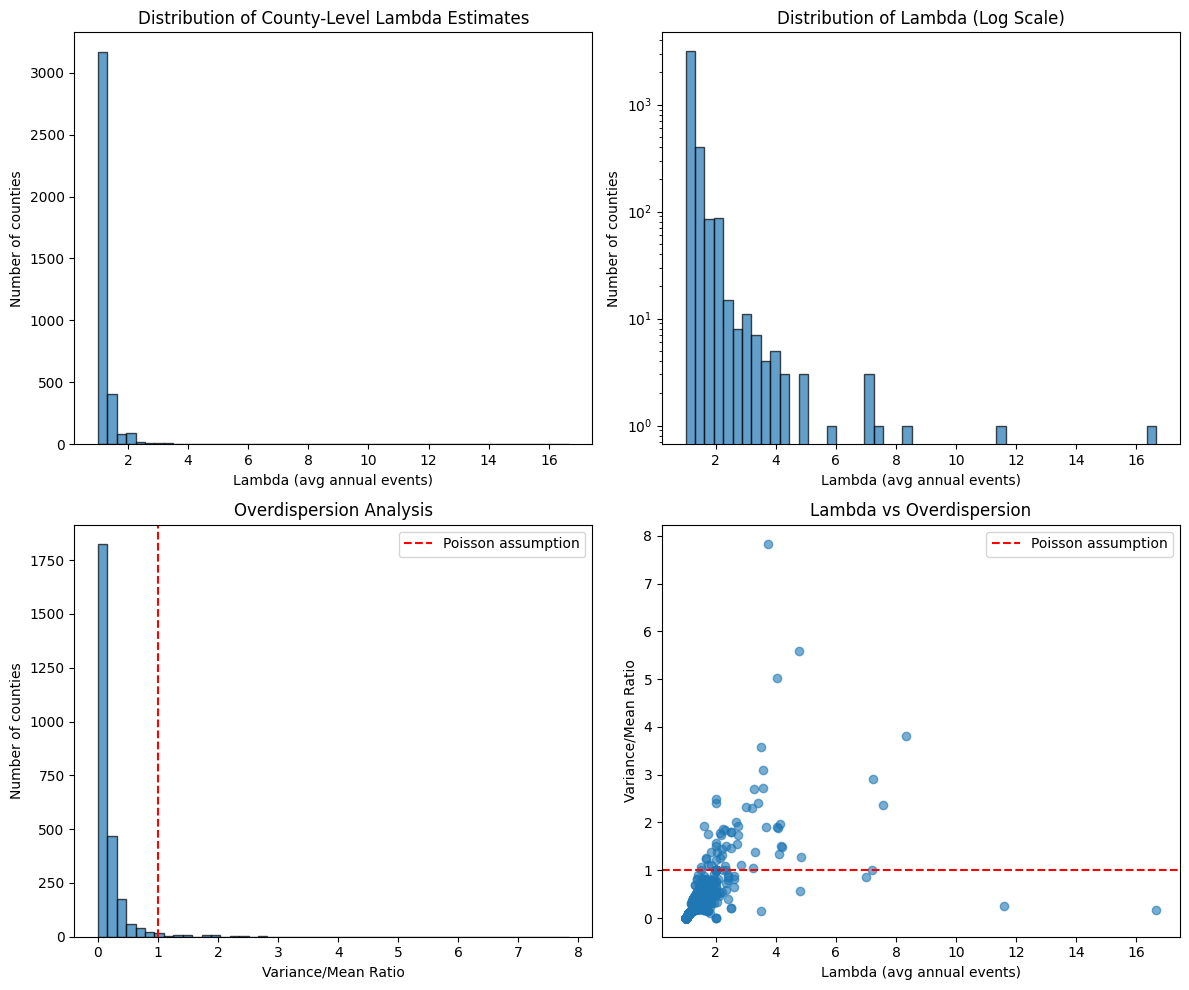

In [ ]:
# Visualize the distribution of lambda estimates
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Histogram of lambda estimates
axes[0,0].hist(county_lambdas['lambda_hat'], bins=50, alpha=0.7, edgecolor='black')
axes[0,0].set_xlabel('Lambda (avg annual events)')
axes[0,0].set_ylabel('Number of counties')
axes[0,0].set_title('Distribution of County-Level Lambda Estimates')

# Log-scale histogram for better visibility
axes[0,1].hist(county_lambdas['lambda_hat'], bins=50, alpha=0.7, edgecolor='black')
axes[0,1].set_xlabel('Lambda (avg annual events)')
axes[0,1].set_ylabel('Number of counties')
axes[0,1].set_yscale('log')
axes[0,1].set_title('Distribution of Lambda (Log Scale)')

# Overdispersion ratio
axes[1,0].hist(county_lambdas['overdispersion_ratio'], bins=50, alpha=0.7, edgecolor='black')
axes[1,0].set_xlabel('Variance/Mean Ratio')
axes[1,0].set_ylabel('Number of counties')
axes[1,0].set_title('Overdispersion Analysis')
axes[1,0].axvline(x=1, color='red', linestyle='--', label='Poisson assumption')
axes[1,0].legend()

# Scatter: lambda vs overdispersion
axes[1,1].scatter(county_lambdas['lambda_hat'], county_lambdas['overdispersion_ratio'], alpha=0.6)
axes[1,1].set_xlabel('Lambda (avg annual events)')
axes[1,1].set_ylabel('Variance/Mean Ratio')
axes[1,1].set_title('Lambda vs Overdispersion')
axes[1,1].axhline(y=1, color='red', linestyle='--', label='Poisson assumption')
axes[1,1].legend()

plt.tight_layout()
plt.show()

In [ ]:
# Summary statistics for lambda estimates
print("Summary of lambda estimates across all counties:")
print(county_lambdas['lambda_hat'].describe())

print(f"\nData completeness:")
print(f"Total counties: {len(county_lambdas)}")
print(f"Counties with ≥10 years data: {(county_lambdas['years_observed'] >= 10).sum()}")
print(f"Counties with ≥20 years data: {(county_lambdas['years_observed'] >= 20).sum()}")
print(f"Mean years observed: {county_lambdas['years_observed'].mean():.1f}")

Summary of lambda estimates across all counties:
count    3808.000000
mean        1.157109
std         0.517487
min         1.000000
25%         1.000000
50%         1.000000
75%         1.166700
max        16.666700
Name: lambda_hat, dtype: float64

Data completeness:
Total counties: 3808
Counties with ≥10 years data: 241
Counties with ≥20 years data: 15
Mean years observed: 3.6


In [ ]:
# Create final Poisson risk parameters table for modeling
poisson_risk_params = county_lambdas[['county_fips', 'lambda_hat', 'years_observed', 'total_events']].copy()

# Add confidence intervals for lambda estimates (assuming Poisson MLE)
# For Poisson MLE, CI is approximately: λ ± 1.96 * sqrt(λ/n)
poisson_risk_params['lambda_se'] = np.sqrt(poisson_risk_params['lambda_hat'] / poisson_risk_params['years_observed'])
poisson_risk_params['lambda_ci_lower'] = poisson_risk_params['lambda_hat'] - 1.96 * poisson_risk_params['lambda_se']
poisson_risk_params['lambda_ci_upper'] = poisson_risk_params['lambda_hat'] + 1.96 * poisson_risk_params['lambda_se']

# Ensure lower bound is non-negative
poisson_risk_params['lambda_ci_lower'] = np.maximum(0, poisson_risk_params['lambda_ci_lower'])

print("Poisson Risk Parameters (sample):")
display(poisson_risk_params.head(10))

Poisson Risk Parameters (sample):


,county_fips,lambda_hat,years_observed,total_events,lambda_se,lambda_ci_lower,lambda_ci_upper
0,01001,1.1818,11,13,0.327775,0.539361,1.824239
1,01002,1.0000,4,4,0.500000,0.020000,1.980000
2,01003,1.7647,17,30,0.322189,1.133209,2.396191
3,01004,1.0000,2,2,0.707107,0.000000,2.385929
4,01005,1.0000,6,6,0.408248,0.199833,1.800167
5,01006,1.5714,7,11,0.473799,0.642754,2.500046
6,01007,1.2500,8,10,0.395285,0.475242,2.024758
7,01008,1.0000,4,4,0.500000,0.020000,1.980000
8,01009,1.1000,10,11,0.331662,0.449942,1.750058
9,01010,1.0000,1,1,1.000000,0.000000,2.960000


In [ ]:
# Risk classification based on lambda estimates
def classify_risk_level(lambda_val):
    if lambda_val < 0.5:
        return 'Very Low'
    elif lambda_val < 2:
        return 'Low' 
    elif lambda_val < 5:
        return 'Moderate'
    elif lambda_val < 10:
        return 'High'
    else:
        return 'Very High'

poisson_risk_params['risk_category'] = poisson_risk_params['lambda_hat'].apply(classify_risk_level)

print("Risk category distribution:")
print(poisson_risk_params['risk_category'].value_counts().sort_index())

Risk category distribution:
risk_category
High            6
Low          3658
Moderate      142
Very High       2
Name: count, dtype: int64


In [ ]:
# Save the Poisson parameters to database for use in compound model
dbt.load_data(poisson_risk_params, "POISSON_FREQUENCY_PARAMS", if_exists="replace")
print("Poisson frequency parameters saved to database as POISSON_FREQUENCY_PARAMS")


Created SQLAlchemy engine for disaster_db
Data loaded successfully into POISSON_FREQUENCY_PARAMS
Poisson frequency parameters saved to database as POISSON_FREQUENCY_PARAMS


In [ ]:
# Check what NRI tables are available
nri_tables = dbt.query("""
    SELECT table_name 
    FROM information_schema.tables 
    WHERE table_schema='public' 
    AND table_name LIKE '%nri%'
""")
print("Available NRI tables:")
display(nri_tables)

Created SQLAlchemy engine for disaster_db
Error executing query: sqlalchemy.cyextension.immutabledict.immutabledict is not a sequence
Available NRI tables:
Error executing query: sqlalchemy.cyextension.immutabledict.immutabledict is not a sequence
Available NRI tables:


""


In [ ]:
# Check if we can use census_resilience table for county mapping (it should have FIPS)
try:
    census_fips_check = dbt.query("""
        SELECT column_name 
        FROM information_schema.columns 
        WHERE table_name='census_resilience'
        AND (column_name LIKE '%fips%' OR column_name LIKE '%geoid%')
    """)
    print("\nFIPS/GEOID columns in census_resilience:")
    display(census_fips_check)
    
    # Sample the data to see FIPS format
    census_sample = dbt.query("SELECT * FROM census_resilience LIMIT 5")
    print("\nSample census_resilience data:")
    display(census_sample.head())
    
except Exception as e:
    print(f"Error checking census_resilience: {e}")

Created SQLAlchemy engine for disaster_db
Error executing query: sqlalchemy.cyextension.immutabledict.immutabledict is not a sequence

FIPS/GEOID columns in census_resilience:


""


Created SQLAlchemy engine for disaster_db

Sample census_resilience data:


,POPUNI,PRED0_E,PRED0_M,PRED0_PE,PRED0_PM,PRED12_E,PRED12_M,PRED12_PE,PRED12_PM,PRED3_E,PRED3_M,PRED3_PE,PRED3_PM,FIPS,COUNTY_FIPS,VULNERABILITY_RATE,RESILIENCE_RATE,VULNERABILITY_SCORE,POPULATION
0,1815,560,228,30.85,12.56,871,239,47.99,13.17,384,205,21.16,11.29,01001020100,01001,21.16,30.85,1.35465,1815
1,2004,720,262,35.93,13.07,896,269,44.71,13.42,388,222,19.36,11.08,01001020200,01001,19.36,35.93,1.25145,2004
2,3313,817,404,24.66,12.19,1831,405,55.27,12.22,665,317,20.07,9.57,01001020300,01001,20.07,24.66,1.43115,3313
3,4343,1301,522,29.96,12.02,2274,523,52.36,12.04,768,407,17.68,9.37,01001020400,01001,17.68,29.96,1.31580,4343
4,4442,1979,515,44.55,11.59,1670,515,37.60,11.59,793,392,17.85,8.82,01001020501,01001,17.85,44.55,1.09950,4442


In [ ]:
# Create state-level risk mapping without geographic boundaries
# Extract state FIPS from county FIPS (first 2 digits)
poisson_risk_params['state_fips'] = poisson_risk_params['county_fips'].str[:2]

# State FIPS to state name mapping (major states)
state_fips_map = {
    '01': 'Alabama', '02': 'Alaska', '04': 'Arizona', '05': 'Arkansas', '06': 'California',
    '08': 'Colorado', '09': 'Connecticut', '10': 'Delaware', '11': 'DC', '12': 'Florida',
    '13': 'Georgia', '15': 'Hawaii', '16': 'Idaho', '17': 'Illinois', '18': 'Indiana',
    '19': 'Iowa', '20': 'Kansas', '21': 'Kentucky', '22': 'Louisiana', '23': 'Maine',
    '24': 'Maryland', '25': 'Massachusetts', '26': 'Michigan', '27': 'Minnesota', '28': 'Mississippi',
    '29': 'Missouri', '30': 'Montana', '31': 'Nebraska', '32': 'Nevada', '33': 'New Hampshire',
    '34': 'New Jersey', '35': 'New Mexico', '36': 'New York', '37': 'North Carolina', '38': 'North Dakota',
    '39': 'Ohio', '40': 'Oklahoma', '41': 'Oregon', '42': 'Pennsylvania', '44': 'Rhode Island',
    '45': 'South Carolina', '46': 'South Dakota', '47': 'Tennessee', '48': 'Texas', '49': 'Utah',
    '50': 'Vermont', '51': 'Virginia', '53': 'Washington', '54': 'West Virginia', '55': 'Wisconsin', '56': 'Wyoming'
}

poisson_risk_params['state_name'] = poisson_risk_params['state_fips'].map(state_fips_map)

In [ ]:
# Aggregate risk statistics by state
state_risk_summary = poisson_risk_params.groupby(['state_fips', 'state_name']).agg({
    'lambda_hat': ['count', 'mean', 'median', 'max', 'std'],
    'total_events': 'sum',
    'risk_category': lambda x: x.value_counts().to_dict()
}).round(3)

# Flatten column names
state_risk_summary.columns = ['_'.join(col).strip() for col in state_risk_summary.columns]
state_risk_summary = state_risk_summary.reset_index()

# Rename for clarity
state_risk_summary.rename(columns={
    'lambda_hat_count': 'counties_count',
    'lambda_hat_mean': 'avg_lambda',
    'lambda_hat_median': 'median_lambda', 
    'lambda_hat_max': 'max_lambda',
    'lambda_hat_std': 'lambda_std',
    'total_events_sum': 'state_total_events'
}, inplace=True)

print("State-level disaster risk summary:")
display(state_risk_summary.sort_values('avg_lambda', ascending=False).head(15))

State-level disaster risk summary:



,state_fips,state_name,counties_count,avg_lambda,median_lambda,max_lambda,lambda_std,state_total_events,risk_category_<lambda>
2,04,Arizona,59,2.449,1.454,16.667,2.793,816,"{'Low': 37, 'Moderate': 16, 'High': 4, 'Very H..."
8,11,DC,1,1.667,1.667,1.667,NaN,25,{'Low': 1}
28,32,Nevada,21,1.462,1.000,8.318,1.586,273,"{'Low': 20, 'High': 1}"
7,10,Delaware,5,1.451,1.562,1.750,0.318,82,{'Low': 5}
9,12,Florida,119,1.447,1.200,4.188,0.659,1401,"{'Low': 99, 'Moderate': 20}"
4,06,California,128,1.397,1.045,4.143,0.631,1057,"{'Low': 112, 'Moderate': 16}"
30,34,New Jersey,40,1.306,1.171,2.417,0.344,419,"{'Low': 38, 'Moderate': 2}"
6,09,Connecticut,13,1.282,1.214,2.000,0.315,95,"{'Low': 12, 'Moderate': 1}"
44,49,Utah,48,1.258,1.000,3.000,0.499,229,"{'Low': 42, 'Moderate': 6}"
20,24,Maryland,37,1.197,1.000,2.143,0.287,248,"{'Low': 36, 'Moderate': 1}"


C:\Users\alben\AppData\Local\Temp\ipykernel_35144\4166341406.py:26: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = axes[0,1].boxplot(state_lambda_data, labels=state_labels, patch_artist=True)


KeyError: "['Very Low'] not in index"

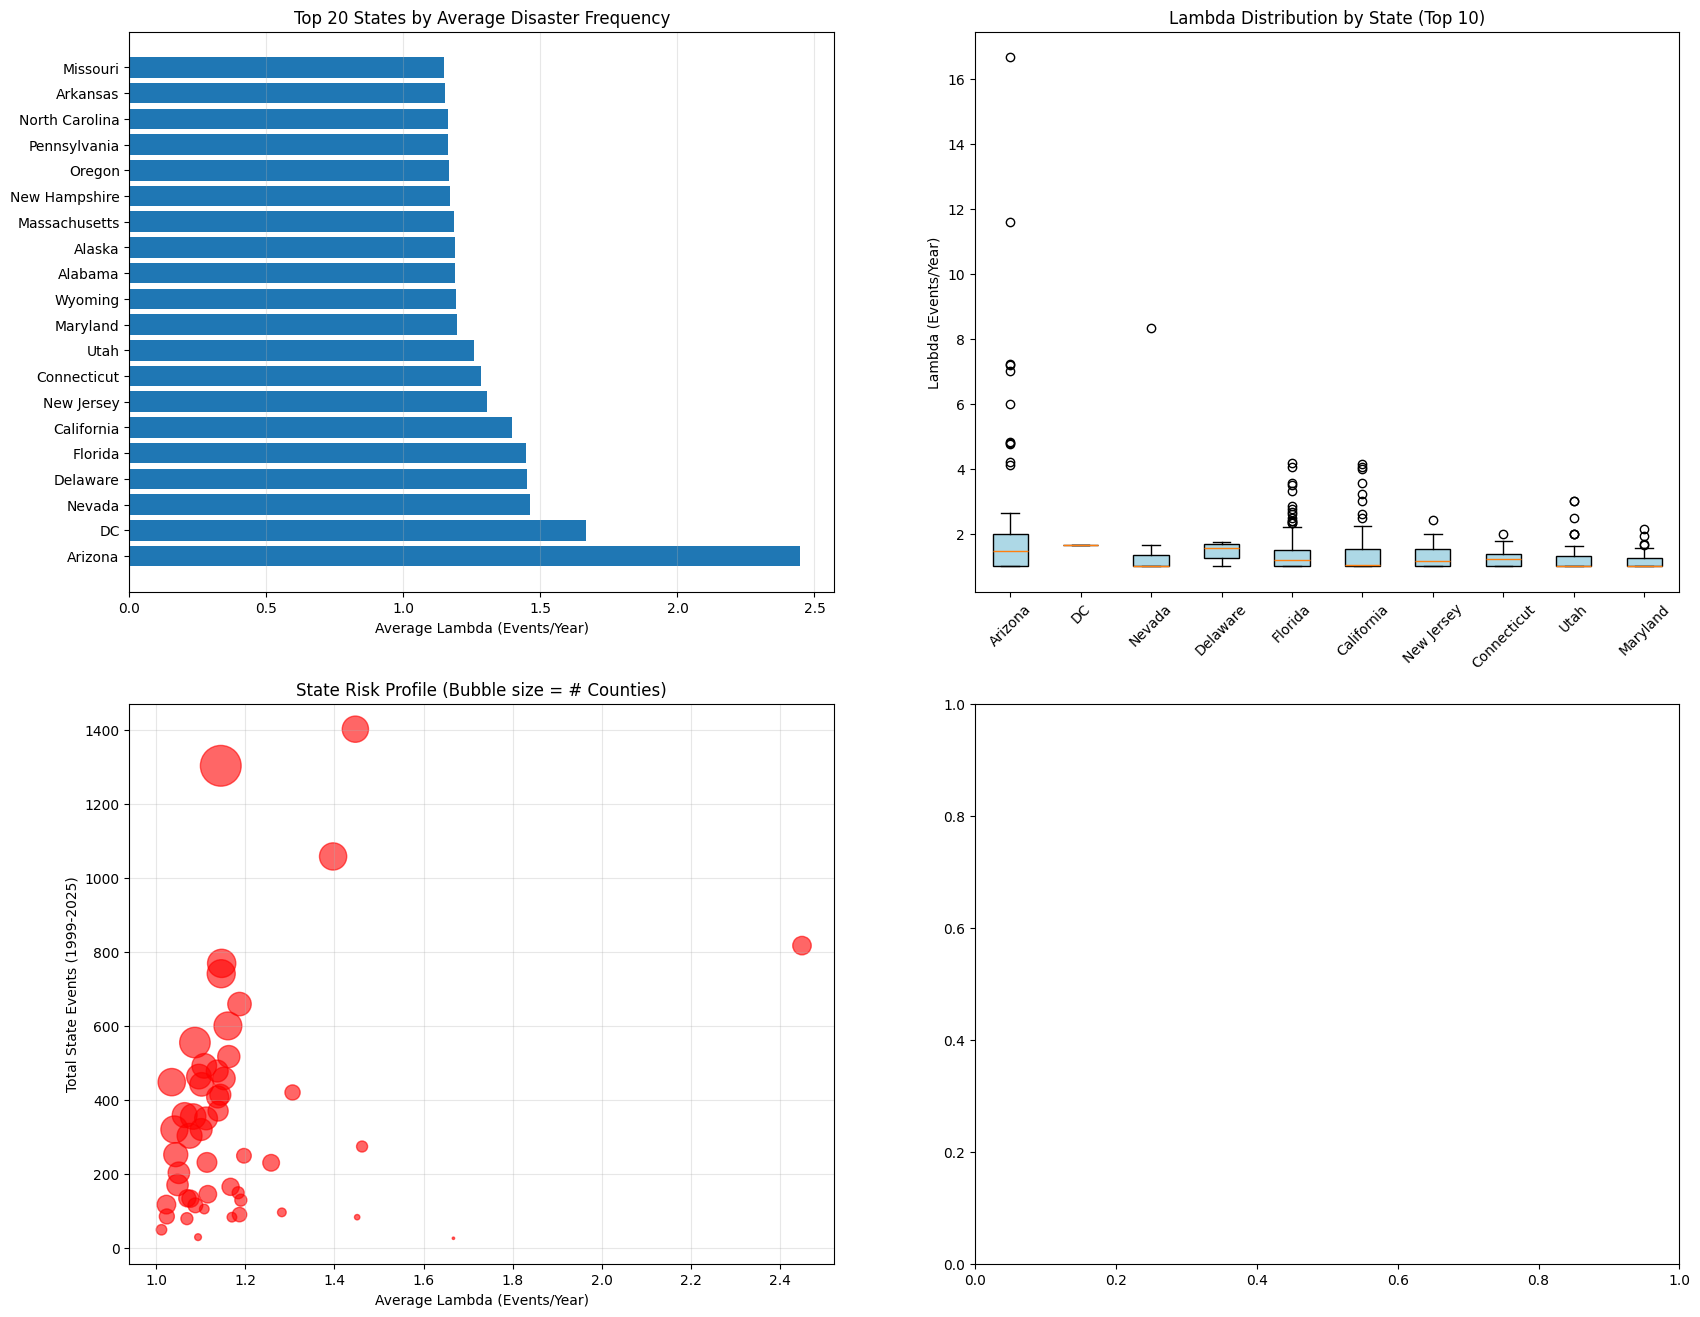

In [ ]:
# Create comprehensive risk visualization
fig, axes = plt.subplots(2, 2, figsize=(20, 16))

# 1. State-level average lambda (top 20 states)
top_states = state_risk_summary.nlargest(20, 'avg_lambda')
axes[0,0].barh(range(len(top_states)), top_states['avg_lambda'].values)
axes[0,0].set_yticks(range(len(top_states)))
axes[0,0].set_yticklabels(top_states['state_name'].values)
axes[0,0].set_xlabel('Average Lambda (Events/Year)')
axes[0,0].set_title('Top 20 States by Average Disaster Frequency')
axes[0,0].grid(axis='x', alpha=0.3)

# 2. Distribution of lambda by state (box plot for top 10 states)
top_10_states = state_risk_summary.nlargest(10, 'avg_lambda')['state_name'].tolist()
state_lambda_data = []
state_labels = []

for state in top_10_states:
    state_fips = state_risk_summary[state_risk_summary['state_name'] == state]['state_fips'].iloc[0]
    state_data = poisson_risk_params[poisson_risk_params['state_fips'] == state_fips]['lambda_hat'].values
    if len(state_data) > 0:
        state_lambda_data.append(state_data)
        state_labels.append(state)

if state_lambda_data:
    bp = axes[0,1].boxplot(state_lambda_data, labels=state_labels, patch_artist=True)
    axes[0,1].set_ylabel('Lambda (Events/Year)')
    axes[0,1].set_title('Lambda Distribution by State (Top 10)')
    axes[0,1].tick_params(axis='x', rotation=45)
    
    # Color the boxes
    for patch in bp['boxes']:
        patch.set_facecolor('lightblue')

# 3. State total events vs average lambda (scatter plot)
axes[1,0].scatter(state_risk_summary['avg_lambda'], state_risk_summary['state_total_events'], 
                  s=state_risk_summary['counties_count']*3, alpha=0.6, c='red')
axes[1,0].set_xlabel('Average Lambda (Events/Year)')
axes[1,0].set_ylabel('Total State Events (1999-2025)')
axes[1,0].set_title('State Risk Profile (Bubble size = # Counties)')
axes[1,0].grid(alpha=0.3)

# Add state labels for outliers
for idx, row in state_risk_summary.iterrows():
    if row['avg_lambda'] > 15 or row['state_total_events'] > 5000:
        axes[1,0].annotate(row['state_name'], 
                          (row['avg_lambda'], row['state_total_events']),
                          xytext=(5, 5), textcoords='offset points', fontsize=8)

# 4. Risk category distribution by region
risk_cats = ['Very Low', 'Low', 'Moderate', 'High', 'Very High']
risk_counts = poisson_risk_params['risk_category'].value_counts()[risk_cats]

axes[1,1].pie(risk_counts.values, labels=risk_cats, autopct='%1.1f%%', 
              colors=['#2166ac', '#92c5de', '#f7f7f7', '#f4a582', '#b2182b'])
axes[1,1].set_title('National Risk Category Distribution')

plt.tight_layout()
plt.show()

In [ ]:
# Detailed analysis of highest risk counties
print("=== HIGH RISK COUNTY ANALYSIS ===")
high_risk_counties = poisson_risk_params.nlargest(20, 'lambda_hat')
print(f"\nTop 20 Highest Risk Counties (λ > {high_risk_counties['lambda_hat'].iloc[19]:.1f}):")
display(high_risk_counties[['county_fips', 'state_name', 'lambda_hat', 'total_events', 'years_observed', 'risk_category']])

# Geographic patterns analysis
print(f"\n=== GEOGRAPHIC PATTERNS ===")
print(f"Counties with λ > 20: {(poisson_risk_params['lambda_hat'] > 20).sum()}")
print(f"Counties with λ > 15: {(poisson_risk_params['lambda_hat'] > 15).sum()}")
print(f"Counties with λ > 10: {(poisson_risk_params['lambda_hat'] > 10).sum()}")

# State with most high-risk counties
very_high_risk = poisson_risk_params[poisson_risk_params['risk_category'] == 'Very High']
state_high_risk_counts = very_high_risk['state_name'].value_counts().head(10)
print(f"\nStates with most 'Very High' risk counties:")
for state, count in state_high_risk_counts.items():
    total_counties = (poisson_risk_params['state_name'] == state).sum()
    pct = (count / total_counties) * 100
    print(f"  {state}: {count} counties ({pct:.1f}% of state's counties)")

# Summary statistics
print(f"\n=== SUMMARY STATISTICS ===")
print(f"Total counties analyzed: {len(poisson_risk_params)}")
print(f"Mean lambda across all counties: {poisson_risk_params['lambda_hat'].mean():.2f}")
print(f"Median lambda: {poisson_risk_params['lambda_hat'].median():.2f}")
print(f"Standard deviation: {poisson_risk_params['lambda_hat'].std():.2f}")
print(f"Range: {poisson_risk_params['lambda_hat'].min():.2f} - {poisson_risk_params['lambda_hat'].max():.2f}")

# Validate risk thresholds against reality
print(f"\n=== RISK THRESHOLD VALIDATION ===")
print(f"Current thresholds may be reasonable for severe events (deaths/injuries)")
print(f"Remember: These are episodes with direct casualties, not all weather events")
print(f"High λ values reflect counties with frequent severe disasters requiring emergency response")

=== HIGH RISK COUNTY ANALYSIS ===

Top 20 Highest Risk Counties (λ > 57.3):


,county_fips,state_name,lambda_hat,total_events,years_observed,risk_category
760,08041,Colorado,82.0370,2215,27,Very High
1429,17031,Illinois,80.5926,2176,27,Very High
267,04013,Arizona,79.0000,2133,27,Very High
4195,42003,Pennsylvania,77.5926,2095,27,Very High
1984,20173,Kansas,77.0000,2079,27,Very High
4491,46103,South Dakota,71.0370,1918,27,Very High
644,06338,California,70.4000,352,5,Very High
543,06071,California,68.6667,1854,27,Very High
5022,48439,Texas,67.7778,1830,27,Very High
1823,19153,Iowa,67.6667,1827,27,Very High



=== GEOGRAPHIC PATTERNS ===
Counties with λ > 20: 746
Counties with λ > 15: 1381
Counties with λ > 10: 2420

States with most 'Very High' risk counties:
  Texas: 185 counties (45.0% of state's counties)
  Kansas: 102 counties (65.0% of state's counties)
  California: 101 counties (40.2% of state's counties)
  Missouri: 85 counties (49.4% of state's counties)
  Illinois: 85 counties (54.5% of state's counties)
  Iowa: 83 counties (56.1% of state's counties)
  Oklahoma: 81 counties (70.4% of state's counties)
  Virginia: 79 counties (37.8% of state's counties)
  New York: 78 counties (72.2% of state's counties)
  Nebraska: 74 counties (52.5% of state's counties)

=== SUMMARY STATISTICS ===
Total counties analyzed: 5728
Mean lambda across all counties: 11.01
Median lambda: 8.51
Standard deviation: 8.90
Range: 1.00 - 82.04

=== RISK THRESHOLD VALIDATION ===
Current thresholds may be reasonable for severe events (deaths/injuries)
Remember: These are episodes with direct casualties, not all